# Evaluation Template

In [1]:
import os
import hydra
import itertools
import torch
from hydra import compose, initialize

from experiments.collect_evaluation_data import define_AM_strategies
from models import evaluate, get_encodings
from core.custom_dataset import CustomDataset
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from PIL import Image
import seaborn as sns
from experiments.eval_utils import get_auroc, ssim_dist, alex_lpips, \
    mse_dist
from core.manipulation_set import FrequencyManipulationSet, RGBManipulationSet
from plotting import (
    collect_fv_data,
    fv_2d_grid_step_vs_model,
    collect_fv_data_by_step,
    fv_2d_grid_model_depth_vs_width,
)

2025-05-07 09:01:18.143319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746601278.154666  336908 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746601278.158296  336908 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746601278.168096  336908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746601278.168105  336908 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746601278.168107  336908 computation_placer.cc:177] computation placer alr

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.ioff()
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

In [3]:
np.random.seed(27)

In [4]:
sns.set_theme()
sns.set_palette("pastel")
sns.set(font_scale=1.2)

In [5]:
cfg_name = "config_cifar_arch"
name = "catfish"

In [6]:
with initialize(version_base=None, config_path="../config"):
    cfg = compose(
        config_name=cfg_name,  # alternatively, "config_mnist"
        overrides=[],
    )
STRATEGY = cfg.strategy
device = "cuda:0"
original_weights = cfg.model.get("original_weights_path", None)
if original_weights:
    original_weights = "{}/{}".format(cfg.model_dir, original_weights)
data_dir = cfg.data_dir
model_dir = cfg.model_dir
output_dir = cfg.output_dir
dataset = cfg.data
dataset_str = cfg.data.dataset_name
default_layer_str = cfg.model.layer
n_out = cfg.model.n_out
image_dims = cfg.data.image_dims
n_channels = cfg.data.n_channels
class_dict_file = cfg.data.get("class_dict_file", None)
if class_dict_file is not None:
    class_dict_file = "." + class_dict_file
fv_sd = float(cfg.fv_sd)
fv_dist = cfg.fv_dist
fv_domain = cfg.fv_domain
cfg.target_img_path = "." + cfg.target_img_path
target_img_path = cfg.target_img_path
batch_size = cfg.batch_size
train_original = cfg.train_original
replace_relu = cfg.replace_relu
alpha = cfg.alpha
w = cfg.w
img_str = cfg.img_str
if img_str is None:
    img_str = os.path.splitext(os.path.basename(target_img_path))[0]
gamma = cfg.gamma
lr = cfg.lr
man_batch_size = cfg.man_batch_size
zero_rate = cfg.get("zero_rate", 0.5)
tunnel = cfg.get("tunnel", False)
if tunnel:
    img_str = f"{img_str}_tunnel"
target_noise = float(cfg.get("target_noise", 0.0))
data = cfg.data.dataset_name
target_img_path = cfg.target_img_path
n_epochs = cfg.epochs
layer_str = cfg.model.layer
target_neuron = int(cfg.model.target_neuron)
image_transforms = hydra.utils.instantiate(dataset.fv_transforms)
normalize = hydra.utils.instantiate(cfg.data.normalize)
denormalize = hydra.utils.instantiate(cfg.data.denormalize)
resize_transforms = hydra.utils.instantiate(cfg.data.resize_transforms)

if "target_act_fn" in cfg.model:
    target_act_fn = hydra.utils.instantiate(cfg.model.target_act_fn)
else:
    target_act_fn = lambda x: x

In [7]:
save_path = f"../results/figures/{cfg_name}/{name}_{STRATEGY}/"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [8]:
noise_ds_type = FrequencyManipulationSet if fv_domain == "freq" else RGBManipulationSet
noise_dataset = noise_ds_type(
    image_dims,
    target_img_path,
    normalize,
    denormalize,
    image_transforms,
    resize_transforms,
    n_channels,
    fv_sd,
    fv_dist,
    zero_rate,
    tunnel,
    device,
)

In [9]:
train_dataset, test_dataset = hydra.utils.instantiate(
    cfg.data.load_function, path=data_dir + cfg.data.data_path
)

train_loader = torch.utils.data.DataLoader(
    CustomDataset(train_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    CustomDataset(test_dataset, class_dict_file),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

In [10]:
plt.rcParams.update(
    {
        "text.usetex": True,
    }
)

In [11]:
kws = list(itertools.product(["A", "B", "C", "D"], [8, 16, 32, 64]))

In [12]:
models = []
original_models = []

for key, width in kws:
    model_name = "cifar_mvgg_" + key + str(width)
    with initialize(version_base=None, config_path="../config"):
        cfg_model = compose(
            config_name="config_cifar_arch",  # alternatively, "config_mnist"
            overrides=[
                f"model.model_name={model_name}",
                f"model.model.cfg={key}",
                f"model.model.width={width}",
            ],
        )
    original_weights = f"{model_name}.pth"
    if original_weights:
        original_weights = "{}/{}".format(model_dir, original_weights)
    default_model = hydra.utils.instantiate(cfg_model.model.model)
    if original_weights is not None:
        default_model.load_state_dict(torch.load(original_weights, map_location=device))
    default_model.to(device)
    default_model.eval()

    before_acc = evaluate(default_model, test_loader, device)

    before_a, target_b, idxs = get_encodings(
        default_model, cfg.model.layer, [test_loader], device
    )

    mdict = {
        "model_str": f"Original {model_name}",
        "model": default_model,
        "acc": before_acc,
        "cfg": cfg,
        "epochs": None,
        "auc": get_auroc(before_a, target_b, target_neuron),
        "jaccard": None,
        "top_k_names": None,
    }
    original_models.append(mdict)

    PATH = "{}/{}/{}/{}/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_model.pth".format(
        output_dir,
        dataset_str,
        model_name,
        "softplus" if replace_relu else "relu",
        img_str,
        fv_domain,
        str(fv_sd),
        fv_dist,
        str(float(alpha)),
        str(w),
        gamma,
        lr,
        fv_dist,
        batch_size,
        man_batch_size,
    )

    img_title = PATH.split("/", 1)[1].split("/", 1)[1].replace("pth", "jpg")
    model = hydra.utils.instantiate(cfg_model.model.model)
    model.to(device)
    model.eval()
    model_dict = torch.load(PATH, map_location=torch.device(device))
    model.load_state_dict(model_dict["model"])

    after_a, target_a, idxs = get_encodings(model, layer_str, [test_loader], device)

    mdict = {
        "model_str": model_name,
        "model": model,
        "acc": model_dict["after_acc"],
        "cfg": cfg,
        "epochs": model_dict["epoch"],
        "auc": get_auroc(after_a, target_a, target_neuron),
        "jaccard": None,
        "top_k_names": None,
    }
    models.append(mdict)

Accuracy of the network on test images: 77.33 %


Accuracy of the network on test images: 82.81 %


Accuracy of the network on test images: 85.25 %


Accuracy of the network on test images: 86.33 %


Accuracy of the network on test images: 78.44 %


Accuracy of the network on test images: 82.61 %


Accuracy of the network on test images: 87.42 %


Accuracy of the network on test images: 89.37 %


Accuracy of the network on test images: 80.13 %


Accuracy of the network on test images: 83.79 %


Accuracy of the network on test images: 88.32 %


Accuracy of the network on test images: 88.05 %


Accuracy of the network on test images: 75.01 %


Accuracy of the network on test images: 83.63 %


Accuracy of the network on test images: 84.62 %


Accuracy of the network on test images: 88.65 %


In [13]:
lr = cfg.eval_lr
nsteps = cfg.eval_nsteps
nvis = 5
n_fv_obs = 30

eval_fv_tuples = [  # ("normal", 0.001),
    (cfg.eval_fv_dist, float(cfg.eval_fv_sd)),  # ("normal", 0.1), ("normal", 1.0)
]

## Define Similarity Functions

In [14]:
dist_funcs = [
    (r"SSIM $\uparrow$", ssim_dist, r"SSIM"),
    (r"LPIPS $\downarrow$", alex_lpips, r"LPIPS"),
    (r"MSE $\downarrow$", mse_dist, r"MSE"),
]

In [15]:
fv_kwargs = define_AM_strategies(lr, nsteps, image_transforms)[STRATEGY]


### Qualitative Analysis: Plot 1

In [16]:
results_df_by_step_basic = collect_fv_data_by_step(
    models=models,
    fv_kwargs=fv_kwargs,
    eval_fv_tuples=eval_fv_tuples,
    noise_gen_class=noise_ds_type,
    image_dims=image_dims,
    normalize=normalize,
    denormalize=denormalize,
    resize_transforms=resize_transforms,
    n_channels=n_channels,
    layer_str=layer_str,
    target_neuron=target_neuron,
    nvis=nvis,
    n_fv_obs=1,
    target_act_fn=target_act_fn,
    dist_funcs=dist_funcs,
    device=device,
)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


In [17]:
results_df_basic = results_df_by_step_basic[
    results_df_by_step_basic["step"] == results_df_by_step_basic["step"].unique()[-1]
]
results_df_basic_ex = results_df_basic[results_df_basic["iter"] == 0]
results_df_basic_ex["key"] = results_df_basic_ex["model"].apply(
    lambda x: x.split("_")[-1][:1]
)
results_df_basic_ex["width"] = r"$\times$" + results_df_basic_ex["model"].apply(
    lambda x: x.split("_")[-1][1:]
)

In [18]:
# iterate through all array in results_df cells and save into a folder as image
for i in range(len(results_df_basic_ex)):
    im = Image.fromarray((results_df_basic_ex.picture.values[i] * 255).astype(np.uint8))
    # save with a str consisting of key and width values from df
    im.save(
        f"{save_path}/{results_df_basic_ex.key.values[i]}_{results_df_basic_ex.width.values[i][7:]}.png"
    )

In [19]:
results_df_basic_og = collect_fv_data(
    models=original_models,
    fv_kwargs=fv_kwargs,
    eval_fv_tuples=eval_fv_tuples,
    noise_gen_class=noise_ds_type,
    image_dims=image_dims,
    normalize=normalize,
    denormalize=denormalize,
    resize_transforms=resize_transforms,
    n_channels=n_channels,
    layer_str=layer_str,
    target_neuron=target_neuron,
    target_act_fn=target_act_fn,
    n_fv_obs=1,
    device=device,
)

In [20]:
results_df_basic_ex_og = results_df_basic_og
results_df_basic_ex_og["key"] = results_df_basic_ex_og["model"].apply(
    lambda x: x.split("_")[-1][:1]
)
results_df_basic_ex_og["width"] = r"$\times$" + results_df_basic_ex_og["model"].apply(
    lambda x: x.split("_")[-1][1:]
)

In [21]:
# iterate through all array in results_df cells and save into a folder as image
for i in range(len(results_df_basic_ex_og)):
    im = Image.fromarray((results_df_basic_ex_og.picture.values[i] * 255).astype(np.uint8))
    # save with a str consisting of key and width values from df
    im.save(
        f"{save_path}/non_man_{results_df_basic_ex_og.key.values[i]}_{results_df_basic_ex_og.width.values[i][7:]}.png"
    )

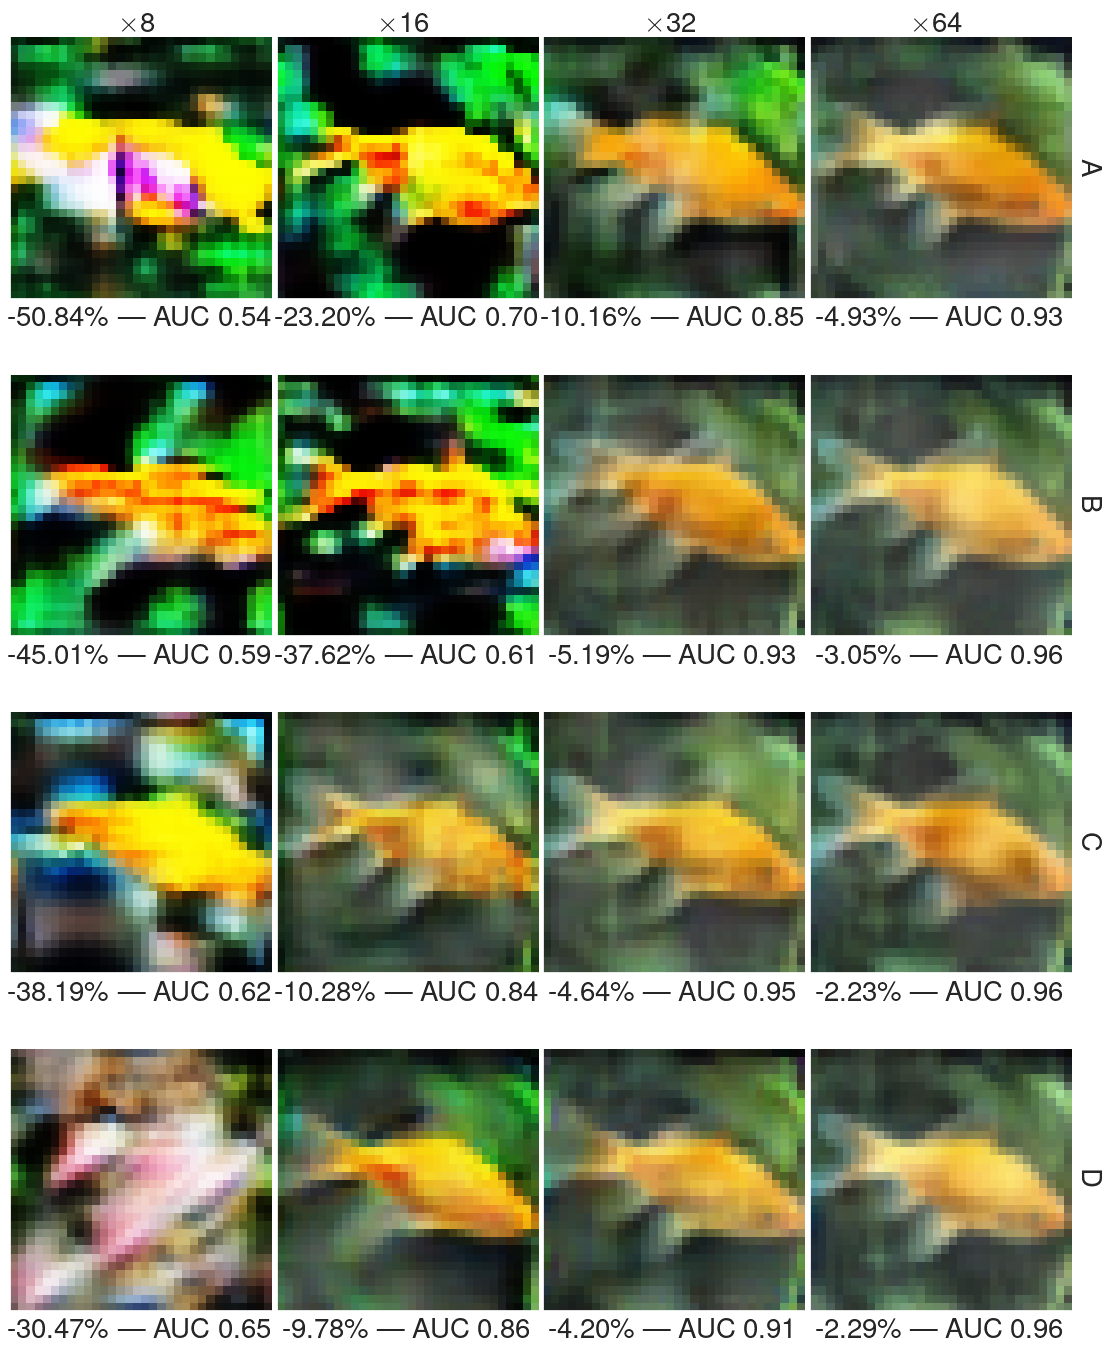

In [22]:
grid = fv_2d_grid_model_depth_vs_width(
    results_df_basic_ex, results_df_basic_ex_og,
)
plt.subplots_adjust(hspace=0.22, wspace=0.02)
# plt.savefig(f"{save_path}/plot_1.png", bbox_inches="tight")
plt.show()

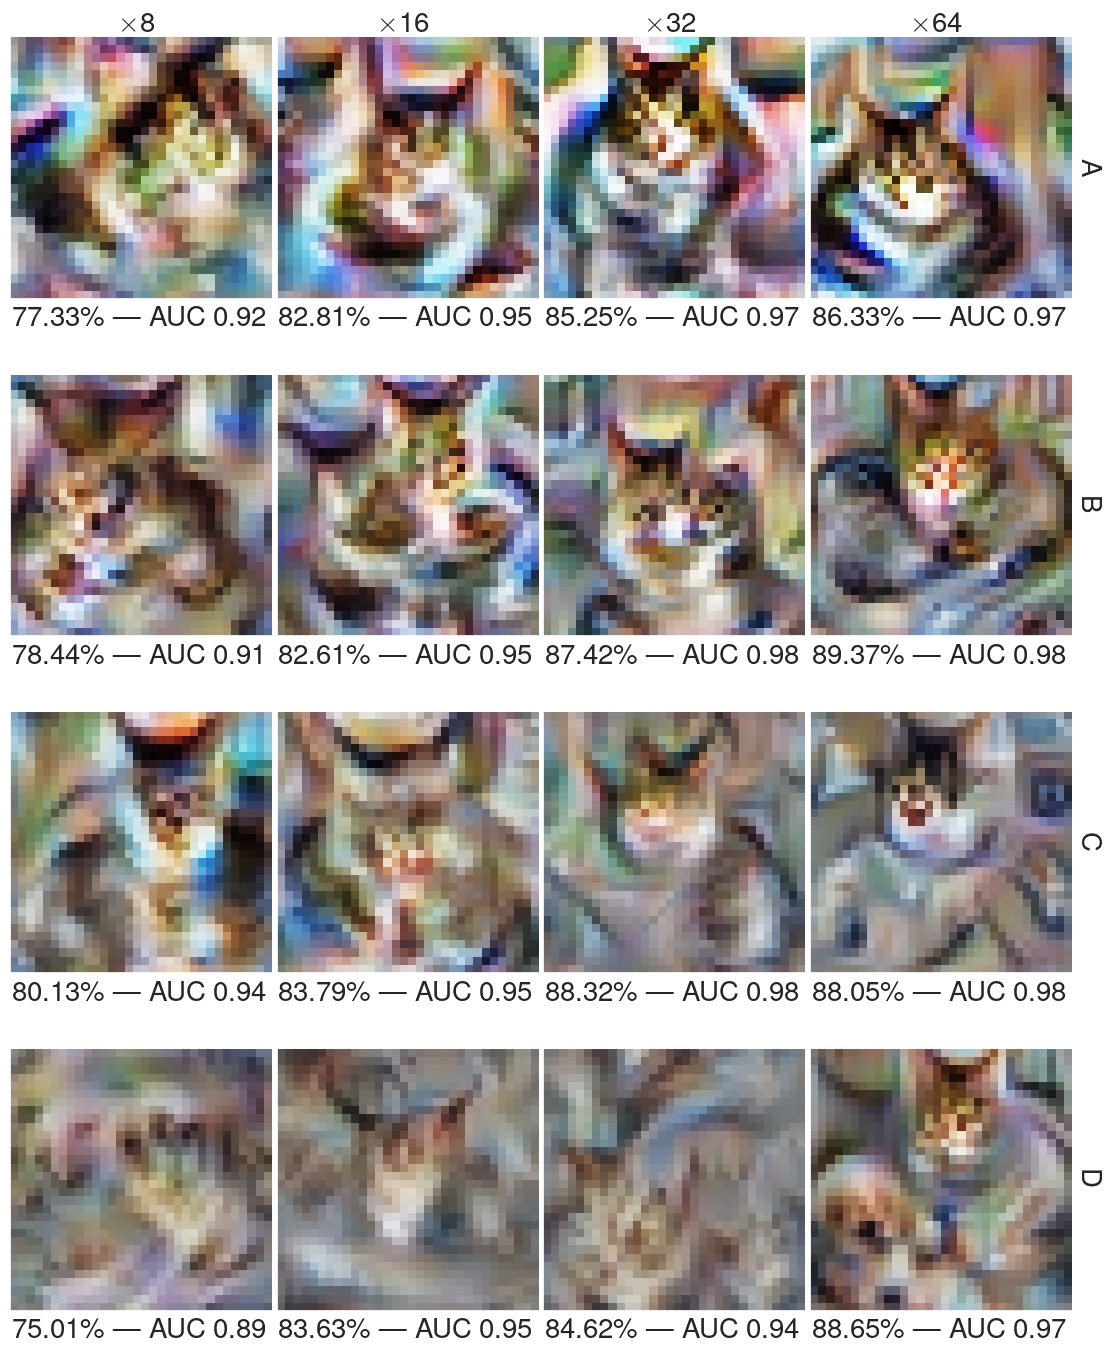

In [23]:
grid = fv_2d_grid_model_depth_vs_width(
    results_df_basic_ex_og,
)
# plt.subplots_adjust(hspace=0.1, wspace=0.0)
plt.savefig(f"{save_path}/plot_1b.png", bbox_inches="tight")
plt.show()

In [24]:
from PIL import Image

im = Image.fromarray((results_df_basic_ex.picture.values[0] * 255).astype(np.uint8))
im.save(f"{save_path}/original_fv.png")

### Qualitative Analysis: Plot 2

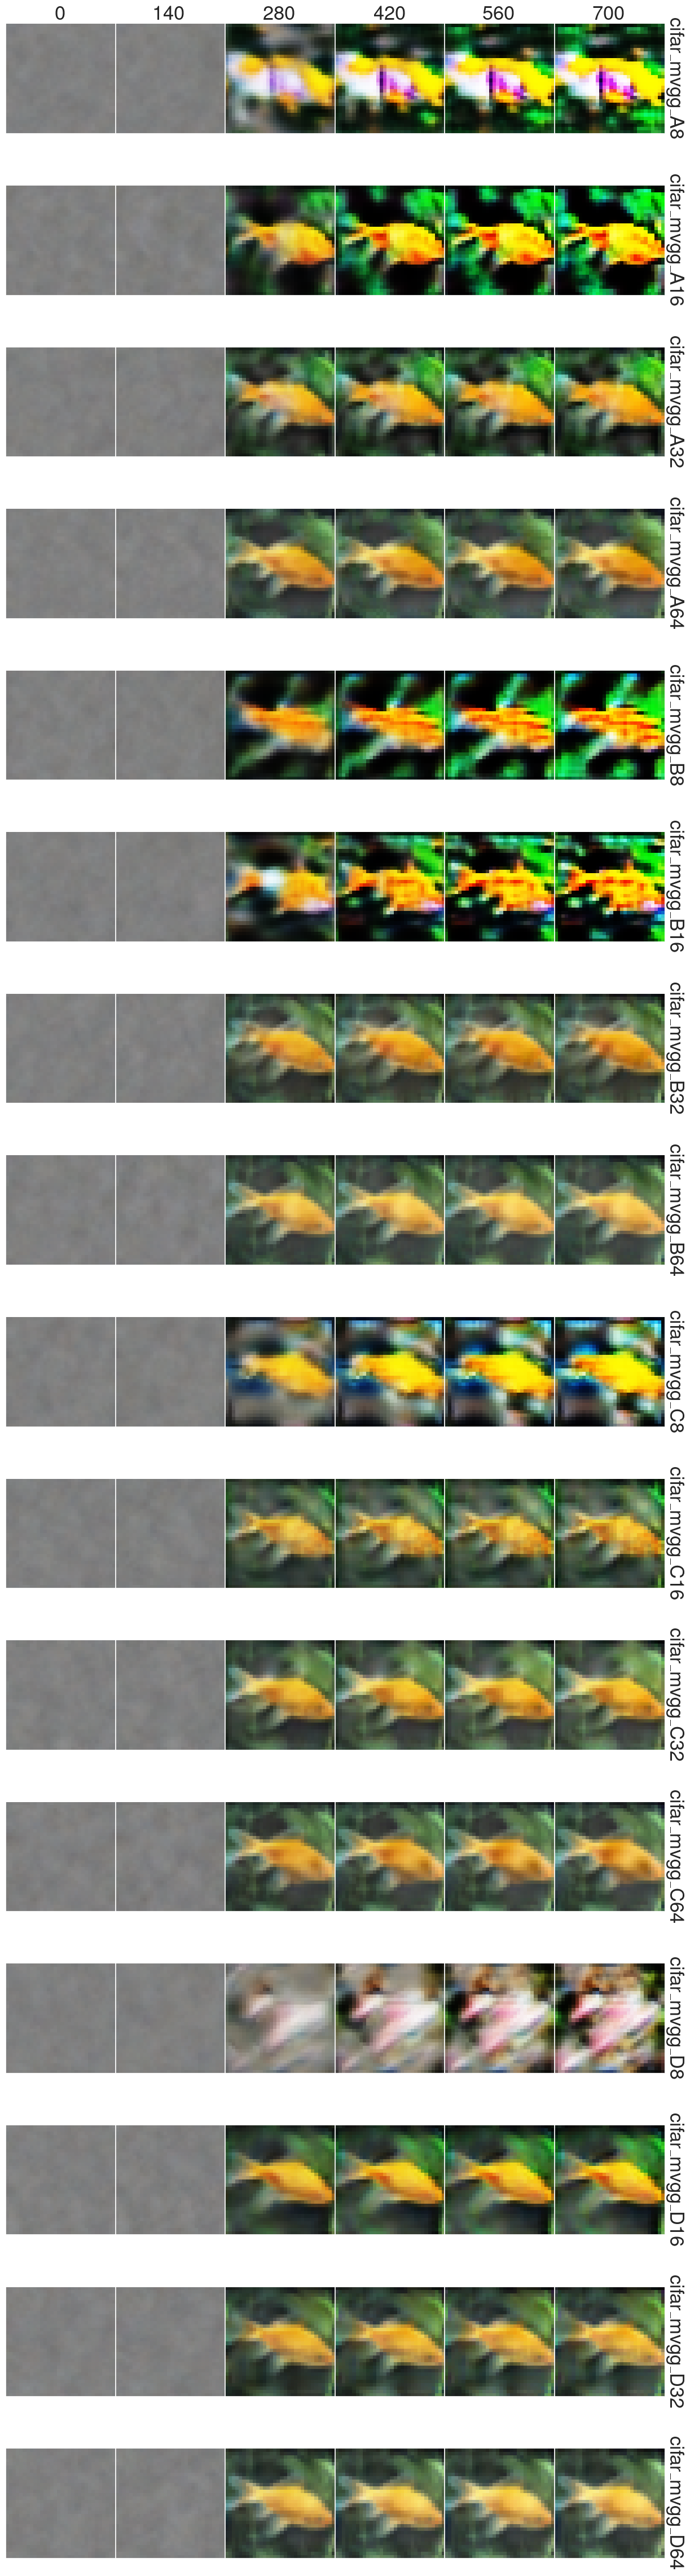

In [25]:
grid = fv_2d_grid_step_vs_model(results_df_by_step_basic, nvis)
plt.subplots_adjust(hspace=0.1, wspace=0.0)
plt.savefig(f"{save_path}/plot_2.png")
plt.show()

### Qualitative Analysis: Plot 3

In [26]:
df = pd.DataFrame()

for neuron in range(10):
    df_neuron = collect_fv_data(
        models=models,
        fv_kwargs=fv_kwargs,
        eval_fv_tuples=eval_fv_tuples,
        noise_gen_class=noise_ds_type,
        image_dims=image_dims,
        normalize=normalize,
        denormalize=denormalize,
        resize_transforms=resize_transforms,
        n_channels=n_channels,
        layer_str=layer_str,
        target_neuron=neuron,
        target_act_fn=target_act_fn,
        n_fv_obs=1,
        device=device,
    )
    df = pd.concat([df, df_neuron], ignore_index=True)

# LateX Table

In [27]:
results_df_basic = collect_fv_data(
    models=models,
    fv_kwargs=fv_kwargs,
    eval_fv_tuples=eval_fv_tuples,
    noise_gen_class=noise_ds_type,
    image_dims=image_dims,
    normalize=normalize,
    denormalize=denormalize,
    resize_transforms=resize_transforms,
    n_channels=n_channels,
    layer_str=layer_str,
    target_neuron=target_neuron,
    dist_funcs=dist_funcs,
    n_fv_obs=n_fv_obs,
    target_act_fn=target_act_fn,
    device=device,
)

In [28]:
results_df_basic["key"] = results_df_basic["model"].apply(
    lambda x: x.split("_")[-1][:1]
)
results_df_basic["width"] = results_df_basic["model"].apply(
    lambda x: x.split("_")[-1][1:]
)

In [29]:
eval_table = results_df_basic.copy()
eval_table = eval_table[["acc", r"LPIPS $\downarrow$", "key", "width"]]
pd.options.display.float_format = "{:,.3f}".format
# eval_table = eval_table.round(2).astype(str)

In [30]:
df1 = (
    pd.pivot_table(
        eval_table,
        values=r"LPIPS $\downarrow$",
        index=["key"],
        columns=["width"],
        aggfunc="mean",
        fill_value=0,
    )
    .round(3)
    .astype(str)
)

In [31]:
df2 = (
    pd.pivot_table(
        eval_table,
        values=r"LPIPS $\downarrow$",
        index=["key"],
        columns=["width"],
        aggfunc="std",
        fill_value=0,
    )
    .round(3)
    .astype(str)
)

In [32]:
mvgg_eval_table = r"$" + df1 + r"\pm" + df2 + r"$"

In [33]:
mvgg_eval_table = mvgg_eval_table[["8", "16", "32", "64"]]

In [34]:
print(mvgg_eval_table.to_latex(escape=False, float_format="{:.3f}".format))

\begin{tabular}{lllll}
\toprule
width & 8 & 16 & 32 & 64 \\
key &  &  &  &  \\
\midrule
A & $0.174\pm0.026$ & $0.077\pm0.007$ & $0.042\pm0.006$ & $0.033\pm0.005$ \\
B & $0.1\pm0.008$ & $0.074\pm0.008$ & $0.039\pm0.008$ & $0.021\pm0.007$ \\
C & $0.078\pm0.015$ & $0.031\pm0.004$ & $0.038\pm0.005$ & $0.034\pm0.008$ \\
D & $0.128\pm0.026$ & $0.042\pm0.007$ & $0.025\pm0.007$ & $0.023\pm0.005$ \\
\bottomrule
\end{tabular}

